# Versatility of GPT-2 for Tasks in other Domains:

tasks: Bit XOR, Bit Memory

In [4]:
#@title Install Package
!pip install transformers

Looking in indexes: http://pypi.mirrors.ustc.edu.cn/simple/


In [5]:
#@title Import Package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from typing import List, Dict
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image

%matplotlib inline 

## Task 1: Bit-wise operation

### part A: Creating the dataset

Simple logic of the generate the data

In [6]:
if torch.cuda.is_available():
   device = 'cuda'
else:
  device = 'cpu'

In [7]:
# randomly generate two n-bits strings and its ground-truth and result
def generate_example(n):
  bits = np.random.randint(low=0, high=2, size=(2, n)) 
  XOR = np.logical_xor(bits[0], bits[1]).astype(np.long) 
  return bits.reshape((2*n)), XOR

In [8]:
n=5
bits, XOR = generate_example(n)
print('  String 1:', bits[:n])
print('  String 2:', bits[n:])
print('Output XOR:', XOR)

  String 1: [1 1 0 0 0]
  String 2: [1 1 0 0 1]
Output XOR: [0 0 0 0 1]


C:\Users\86182\AppData\Local\Temp\ipykernel_13036\3694533259.py:4: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  XOR = np.logical_xor(bits[0], bits[1]).astype(np.long)


Create the dataset

In [9]:
class BitWiseDataset(torch.utils.data.Dataset):
  def __init__(self, n, size):
    self.n = n
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(2, self.n))
    And = np.logical_xor(bits[0], bits[1]).astype(np.int64)
    return torch.tensor(bits.reshape((2*self.n)), dtype=torch.long).to(device), torch.tensor(And, dtype=torch.long).to(device)

def generate_data_loaders(n, batch_size, data_size = 1000, train_size=0.8):
  dataset = BitWiseDataset(n, size=data_size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


### part B: Modify and train the pretained transformer to our specific tasks
Load the pretain transformer GPT2-model and freeze the weights of the self-attention and feedforward layers.



In [10]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

d:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\86182\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
for name, param in gpt2.named_parameters():
# freeze all parameters except the layernorm and positional embeddings 
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True 
  else:
    param.requires_grad = False

Design and train your own network using pretrained GPT2 model as universal computational engine. You need to design

*   An input embedding layer, which projects your input to accommodate GPT2 input demension

*   An output Linear layer and loss function

In [ ]:
class Bit_wise_transformer(nn.Module):
  def __init__(self, engine, bitLength, input_dim, engine_embed_dim, n_class = 2):
    super().__init__()
    self.n = bitLength
    self.input_embed = nn.Embedding(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
    embeddings = self.input_embed(x)
    hidden_state = self.engine(inputs_embeds=embeddings).last_hidden_state[:,self.n:]
    logits = self.output_layer(hidden_state)[0]
    return logits

In [ ]:
# generate the training and testing data
train_loader, test_loader = generate_data_loaders(n=5, batch_size=1,data_size = 1000, train_size=0.8)

In [ ]:
#@title train the modified model
# create an instance of the model
model = Bit_wise_transformer(
      gpt2, 
      bitLength = 5,
      input_dim = 2, 
      engine_embed_dim = 768
).to(device)


# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 5

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    running_loss = 0.0
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        accuracy = torch.mean((torch.argmax(outputs, dim=-1) == labels.flatten()).float())
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
              #print(f'Epoch [{epoch + 1}/{num_epochs}], Data [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
            losses.append(loss.item())
            train_acc.append(accuracy.item())
        
    # Validation
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device=device, dtype=torch.long)
          labels = labels.to(device=device, dtype=torch.long)
          outputs = model(inputs)
          accuracy = torch.mean((torch.argmax(outputs, dim=-1) == labels.flatten()).float())
          val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)


plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')
del model
torch.cuda.empty_cache()

## Task 2: Bit Memory.

### part A: Loading the dataset

Simple logic of the generate the data

In [ ]:
if torch.cuda.is_available():
   device = 'cuda'
else:
  device = 'cpu'

Create the dataset

In [ ]:
class Dataset:

    def __init__(self, device='cpu'):
        self.device = device
        self._ind = 0

    def get_batch(self, batch_size, train=True):
        x, y = self.get_batch_np(batch_size, train=train)
        x = torch.from_numpy(x).to(device=self.device, dtype=torch.float32)
        y = torch.from_numpy(y).to(device=self.device, dtype=torch.long)
        self._ind += 1
        return x, y

    def get_batch_np(self, batch_size, train):
        raise NotImplementedError

    def start_epoch(self):
        self._ind = 0

In [ ]:
class BitMemoryDataset(Dataset):

    def __init__(self, n=1000, num_patterns=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n = n
        self.num_patterns = num_patterns

    def get_batch_np(self, batch_size, train):
        bits = np.random.randint(low=0, high=2, size=(batch_size, self.num_patterns, self.n))
        bits = 2 * bits - 1
        query_inds = np.random.randint(low=0, high=self.num_patterns, size=batch_size)
        query_bits = bits[range(batch_size), query_inds]
        mask = np.random.randint(low=0, high=2, size=query_bits.shape)
        masked_query_bits = mask * query_bits
        masked_query_bits = masked_query_bits.reshape(batch_size, 1, self.n)
        x = np.concatenate([bits, masked_query_bits], axis=1)
        y = query_bits
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [ ]:
class BitMemoryDataset(torch.utils.data.Dataset):
  def __init__(self,bit_length =1000, num_patterns=5, size = 100):
    self.bit_length = bit_length
    self.num_patterns = num_patterns
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(1, self.num_patterns, self.bit_length))
    bits = 2 * bits - 1
    query_inds = np.random.randint(low=0, high=self.num_patterns, size=1)
    query_bits = bits[range(1), query_inds]
    mask = np.random.randint(low=1, high=2, size=query_bits.shape)
    masked_query_bits = mask * query_bits
    masked_query_bits = masked_query_bits.reshape(1, 1, self.bit_length)
    x = np.concatenate([bits, masked_query_bits], axis=1)
    y = query_bits

    return torch.tensor(x, dtype=torch.float32).squeeze(), torch.tensor(y, dtype=torch.long).squeeze()



def generate_data_loaders(size = 100, batch_size = 1, train_size=0.8):
  dataset = BitMemoryDataset(size=size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

### part B: Modified the pretained transformer to our specific tasks
Load the pretain transformer GPT2-model and freeze the weights of the self-attention and feedforward layers.



In [ ]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

In [ ]:
# show the name of all the para your are able to modified in this model
for name, param in gpt2.named_parameters():
  print(name)

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

In [ ]:
for name, param in gpt2.named_parameters():
# freeze all parameters except the layernorm and positional embeddings 
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True 
  else:
    param.requires_grad = False

Design and train your own network using pretrained GPT2 model as universal computational engine. You need to design

*   An input embedding layer, which projects your input to accommodate GPT2 input demension

*   An output Linear layer and loss function

In [ ]:
class Bit_Memory_transformer(nn.Module):
  def __init__(self, engine,input_dim, engine_embed_dim, n_class, patch_size):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = n_class
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
        orig_dim = x.shape[-1]
        ratio = orig_dim // self.input_dim
        x = x.reshape(x.shape[0], x.shape[1] * ratio, self.input_dim)
        flattened_input = x.view(-1, 50)

        x = self.input_embed(flattened_input)
        
        x = self.engine(inputs_embeds = x.unsqueeze(0)).last_hidden_state
        x = x[:,-ratio:]
        x = self.output_layer(x)

        x = x.reshape(x.shape[0], x.shape[1] // ratio, ratio * self.output_dim)
        return x
        

    

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()
task = 'bit-memory'
n = 100
def loss_fn(out, y, x=None):
  out = torch.reshape(out, (-1, n, 2))
  ids = torch.zeros(y.shape).to(device=y.device).long()
  if task == 'bit-memory':
      ids[y < 0], ids[y > 0] = 0, 1
  else:
      ids[y < 0.5], ids[y > 0.5] = 0, 1
  out, ids = torch.reshape(out, (-1, 2)), torch.reshape(ids, (-1,))
  return ce_loss(out, ids)

def accuracy_fn(preds, true, x=None):
    if task == 'bit-memory':
        preds = preds.reshape(-1, n, 2).argmax(-1) * 2 - 1
    else:
        preds = preds.reshape(-1, n, 2).argmax(-1)
    if task == 'bit-memory':
        return (np.sign(preds) == np.sign(true)).mean()
    else:
        return ((preds > 0.5) == (true > 0.5)).mean()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Val Accuracy')

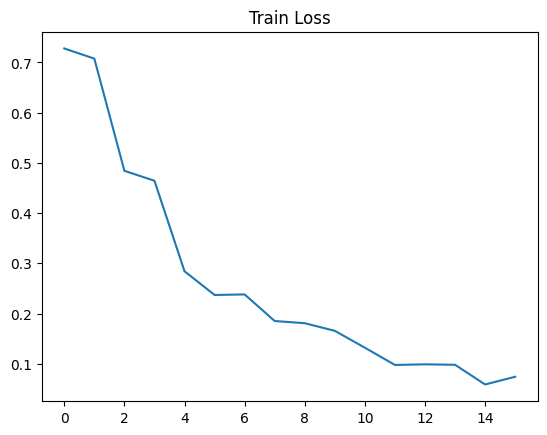

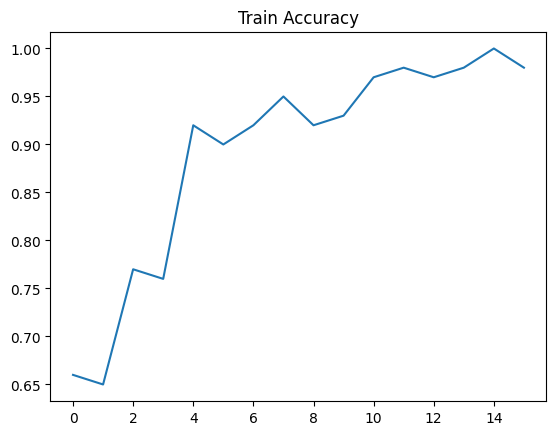

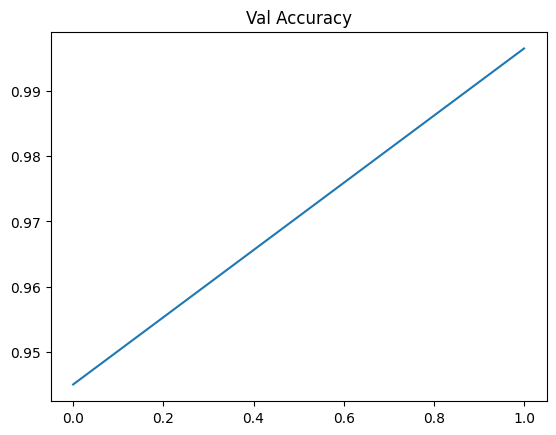

In [ ]:
model = Bit_Memory_transformer(
    gpt2, 
    input_dim = 50, 
    engine_embed_dim = 768,
    n_class= 2*50,
    patch_size = 50
)

def get_loss(x,y,return_acc = True):
  out = model(x)
  loss = loss_fn(out, y, x=x)
  accs = accuracy_fn(
                out.detach().cpu().numpy(),
                y.detach().cpu().numpy(),
                x=x.detach().cpu().numpy(),
            )
  return loss, accs

train_loader, test_loader = generate_data_loaders(size = 100, batch_size=1, train_size=0.8)
# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 2

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
      loss, acc = get_loss(inputs, labels, return_acc=True)
      loss.backward()
      running_loss += loss.detach().cpu().item()
      optimizer.step()
      optimizer.zero_grad()

      data_iterator.set_postfix(loss=loss.item())

      if (i + 1) % 10 == 0:
            losses.append(loss.item())
            train_acc.append(acc.item())

    # validation loop
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
        loss, acc = get_loss(inputs, labels, return_acc=True)
        val_acc.append(acc.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')